In [1]:
# 前根收 ema 38 以下，此根收 ema 38 以上，且量大於前根 2x
# ! conda install -c conda-forge ta --yes

In [2]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1641028611000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
tp_atr = 12

# stop loss determine candlestick
sl_det = 'Close'

ema_int = 38

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [6]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

                Close_Time     Open    Close     High      Low      Volume
0      2022-01-01 18:59:59  3718.67  3691.39  3731.88  3673.46  10412.4737
1      2022-01-01 19:59:59  3691.39  3693.37  3712.19  3691.02   4786.2173
2      2022-01-01 20:59:59  3693.38  3716.28  3718.24  3693.37   6595.5530
3      2022-01-01 21:59:59  3716.28  3710.03  3724.93  3706.32   5715.5972
4      2022-01-01 22:59:59  3710.04  3697.61  3713.68  3691.88   5365.4474
...                    ...      ...      ...      ...      ...         ...
10913  2023-04-01 12:59:59  1825.99  1826.92  1829.67  1824.40   7221.1098
10914  2023-04-01 13:59:59  1826.91  1825.58  1827.31  1820.19  10417.5098
10915  2023-04-01 14:59:59  1825.58  1823.06  1825.64  1812.12  22064.6505
10916  2023-04-01 15:59:59  1823.07  1823.46  1826.23  1818.83  12152.5073
10917  2023-04-01 16:59:59  1823.47  1823.04  1824.61  1821.07   6517.1126

[10918 rows x 6 columns]


In [7]:
df = raw_df.copy()

In [8]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down

def indicators(df, ema_int):

# ema
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
   

# df['kd_cross'] = check_cross(df, kd_dir)
    
    return df


In [9]:
indicators(df, ema_int)

print(df)

                Close_Time     Open    Close     High      Low      Volume  \
0      2022-01-01 18:59:59  3718.67  3691.39  3731.88  3673.46  10412.4737   
1      2022-01-01 19:59:59  3691.39  3693.37  3712.19  3691.02   4786.2173   
2      2022-01-01 20:59:59  3693.38  3716.28  3718.24  3693.37   6595.5530   
3      2022-01-01 21:59:59  3716.28  3710.03  3724.93  3706.32   5715.5972   
4      2022-01-01 22:59:59  3710.04  3697.61  3713.68  3691.88   5365.4474   
...                    ...      ...      ...      ...      ...         ...   
10913  2023-04-01 12:59:59  1825.99  1826.92  1829.67  1824.40   7221.1098   
10914  2023-04-01 13:59:59  1826.91  1825.58  1827.31  1820.19  10417.5098   
10915  2023-04-01 14:59:59  1825.58  1823.06  1825.64  1812.12  22064.6505   
10916  2023-04-01 15:59:59  1823.07  1823.46  1826.23  1818.83  12152.5073   
10917  2023-04-01 16:59:59  1823.47  1823.04  1824.61  1821.07   6517.1126   

               ema        atr        rsi     slow_k     slow_d 

In [10]:
def conditions(df):

    for index, row in df.iterrows():
        
        df['c1'] = df['Close'].shift(1) < df['ema']
        
        df['c2'] = df['Close'] > df['ema']
        
        df['c3'] = df['Volume'] > df['Volume'].shift(1) * 1.8

        
    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema,atr,rsi,slow_k,slow_d,c1,c2,c3,signal,open_entry
0,2022-01-01 18:59:59,3718.67,3691.39,3731.88,3673.46,10412.4737,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False
1,2022-01-01 19:59:59,3691.39,3693.37,3712.19,3691.02,4786.2173,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False
2,2022-01-01 20:59:59,3693.38,3716.28,3718.24,3693.37,6595.5530,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False
3,2022-01-01 21:59:59,3716.28,3710.03,3724.93,3706.32,5715.5972,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False
4,2022-01-01 22:59:59,3710.04,3697.61,3713.68,3691.88,5365.4474,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913,2023-04-01 12:59:59,1825.99,1826.92,1829.67,1824.40,7221.1098,1812.609320,12.175531,57.207910,44.909972,46.219969,False,True,False,False,False
10914,2023-04-01 13:59:59,1826.91,1825.58,1827.31,1820.19,10417.5098,1813.274483,11.814422,56.102841,40.270083,40.434556,False,True,False,False,False
10915,2023-04-01 14:59:59,1825.58,1823.06,1825.64,1812.12,22064.6505,1813.776305,11.936249,53.990654,35.623575,40.267877,False,True,True,False,False
10916,2023-04-01 15:59:59,1823.07,1823.46,1826.23,1818.83,12152.5073,1814.272904,11.612231,54.284860,36.926083,37.606580,False,True,False,False,False


In [12]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
open_val = entry_df['Open']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = open_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, sl_det] < stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


                Close_Time     Open    Close     High      Low      Volume  \
210    2022-01-10 12:59:59  3155.04  3175.18  3185.00  3152.00  12759.5370   
211    2022-01-10 13:59:59  3175.18  3174.00  3181.00  3167.40   8635.7041   
214    2022-01-10 16:59:59  3163.24  3145.27  3169.91  3138.01  11088.7354   
316    2022-01-14 22:59:59  3210.15  3276.55  3284.74  3204.00  21039.5464   
317    2022-01-14 23:59:59  3276.26  3278.00  3299.69  3259.08  20708.0325   
...                    ...      ...      ...      ...      ...         ...   
10773  2023-03-26 16:59:59  1752.55  1774.75  1787.64  1749.80  36934.3846   
10774  2023-03-26 17:59:59  1774.75  1774.99  1782.16  1771.14  18484.1955   
10794  2023-03-27 13:59:59  1764.63  1750.30  1765.62  1747.23  19518.6826   
10897  2023-03-31 20:59:59  1792.90  1807.08  1812.67  1790.56  28675.0214   
10898  2023-03-31 21:59:59  1807.07  1826.30  1840.00  1804.73  71045.1061   

               ema        atr        rsi     slow_k     slow_d 

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema', 'atr', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] + tp_atr * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        

# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():

    if row['position'] == 'Buy':

        consec_entry += 1
        position_amt_sum += row['amt']

    elif row['position'] in ['Sell', 'Stop']:

        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum

        position_amt_sum += row['amt']

        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum

        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum

        consec_entry = 0
        position_amt_sum = 0

    else:
        pass


profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print(pos)
pos.to_csv('pos.csv')



   Profit     Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0   361.3  200.27      800.59    -93.98          3       5047.64   71.58%   

  Win_Rate  
0   10.59%  
              Close_Time     Open    Close     High      Low          ema  \
0    2022-01-10 13:59:59  3175.18  3174.00  3181.00  3167.40  3156.300712   
1    2022-01-10 16:59:59  3163.24  3145.27  3169.91  3138.01  3156.310323   
2    2022-01-14 23:59:59  3276.26  3278.00  3299.69  3259.08  3274.410782   
3    2022-01-18 01:59:59  3228.02  3207.23  3231.56  3192.59  3287.658093   
4    2022-01-20 22:59:59  3181.81  3220.03  3225.27  3181.79  3140.977917   
..                   ...      ...      ...      ...      ...          ...   
189  2023-03-23 02:59:59  1787.19  1772.27  1810.93  1750.90  1787.659863   
190  2023-03-23 23:59:59  1803.53  1836.99  1857.16  1801.13  1765.664645   
191  2023-03-25 01:59:59  1762.76  1737.51  1764.47  1726.40  1785.371777   
192  2023-03-26 17:59:59  1774.75  1774.99  1782.

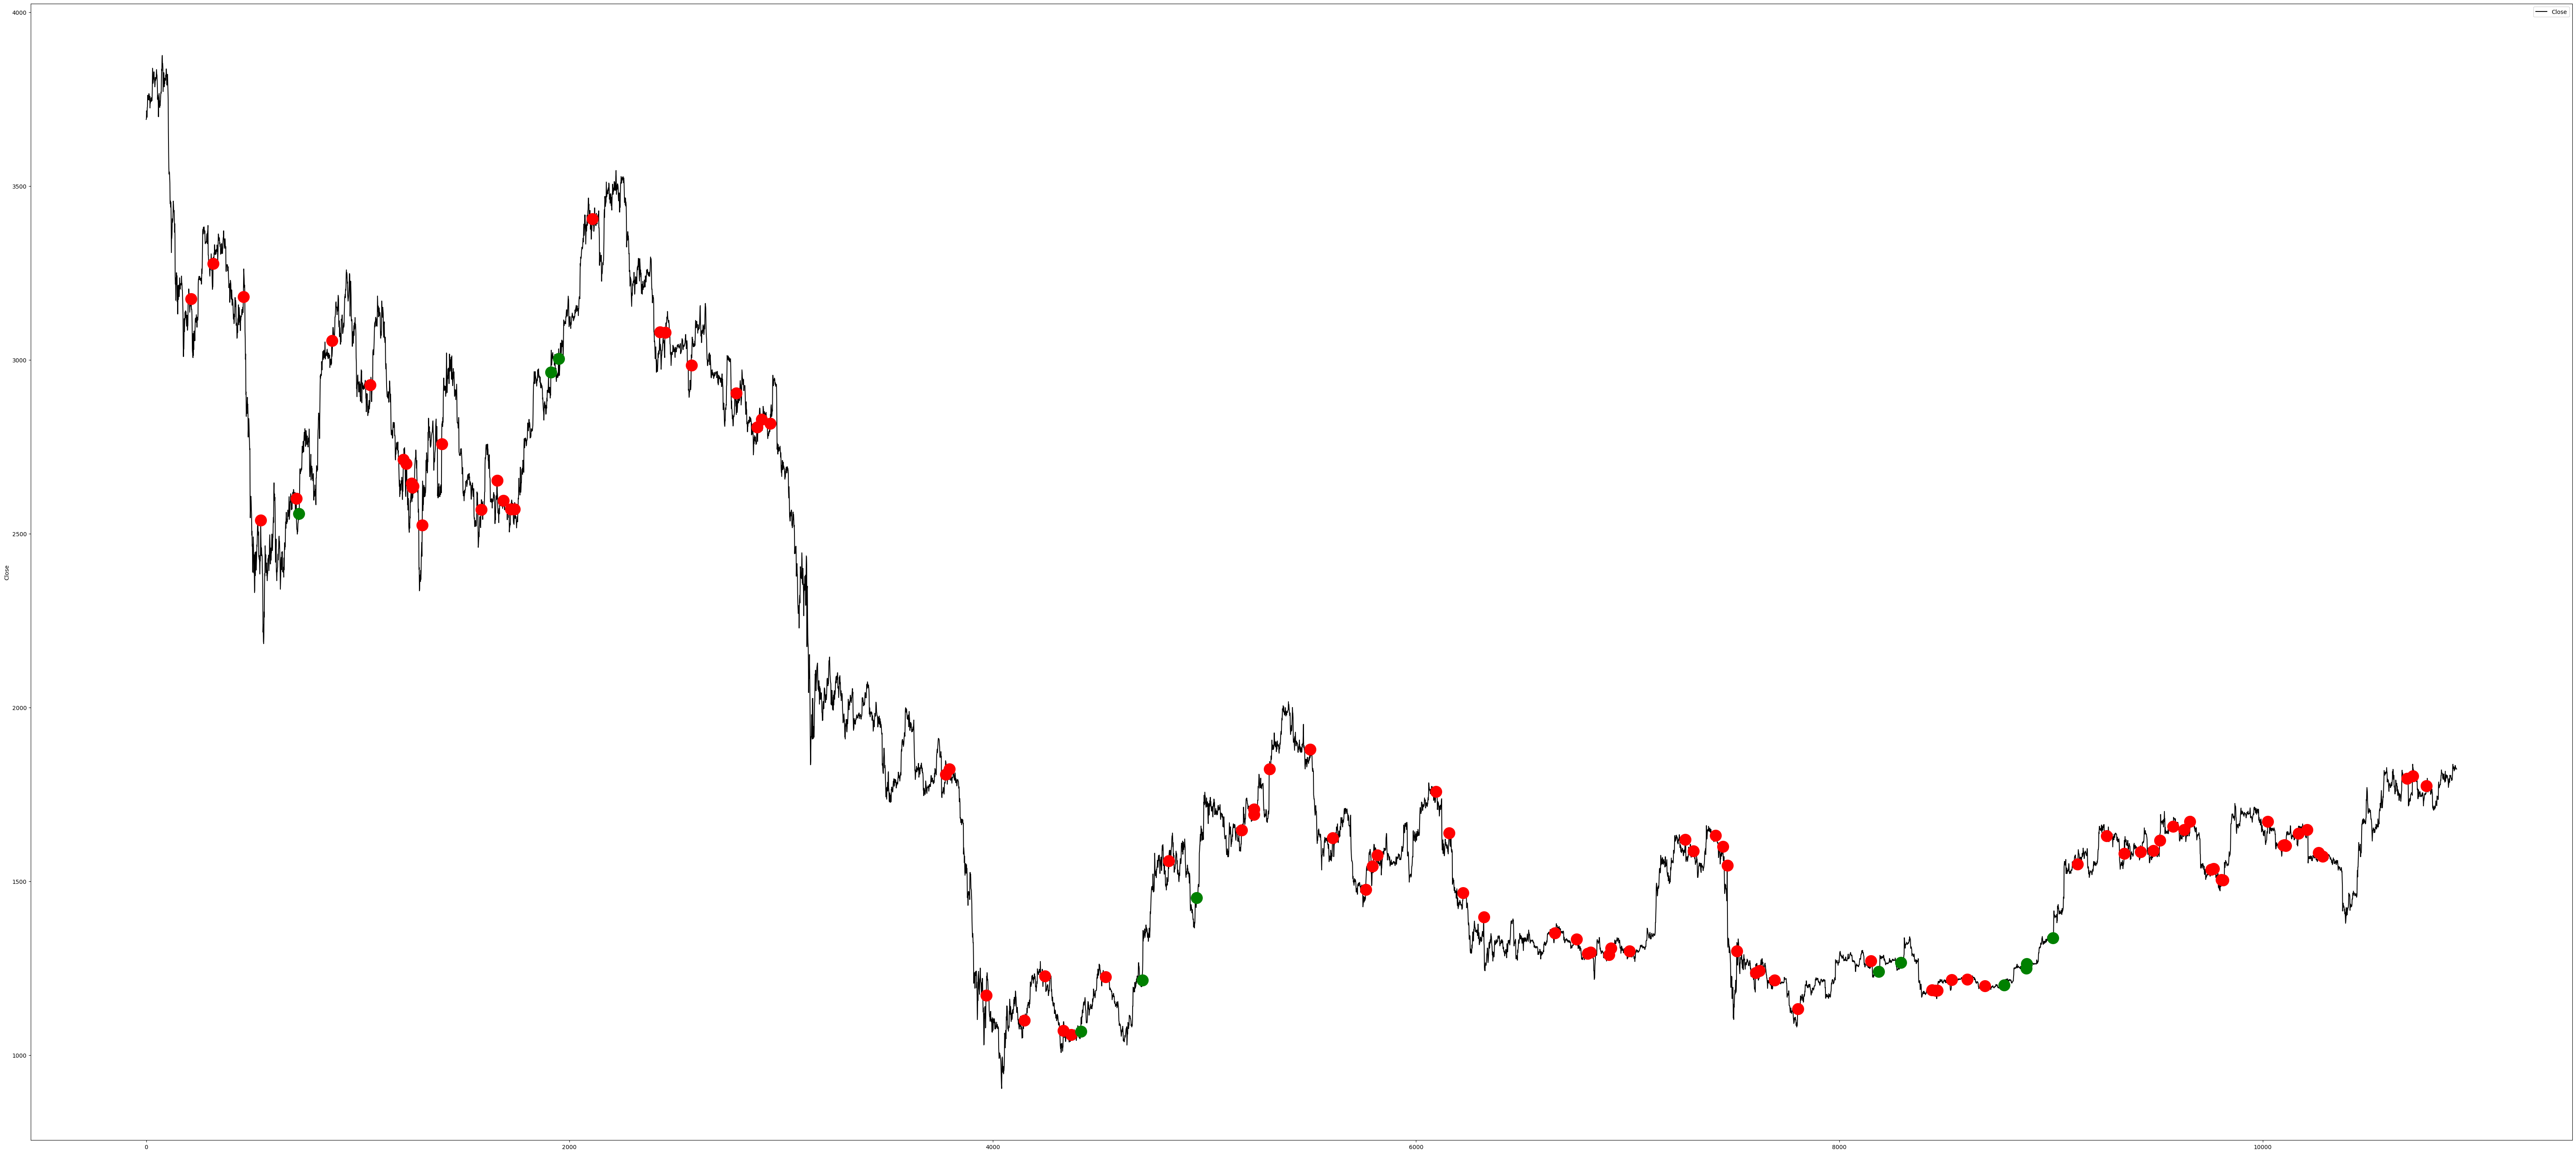

In [14]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位